# Deteksi Transaksi Bitcoin Ilegal Menggunakan Graph Neural Networks

# 1. Project Preparation and Environment Configuration

## 1.1 Introduction and Library Imports

In [1]:
!pip install python-louvain
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.3 MB/s eta 0:00:0000:01


In [2]:
# Untuk manipulasi data dan komputasi numerik
import numpy as np
import pandas as pd

# Untuk membangun dan melatih model deep learning
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, GINConv

# Untuk membangun dan menganalisis graf
import networkx as nx
from scipy.stats import mannwhitneyu  # uji statistik non-parametrik
import community as community_louvain  # deteksi komunitas dalam graf
from collections import defaultdict  # struktur data untuk manajemen koleksi berlabel

# Untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns

# Untuk metrik evaluasi machine learning
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, classification_report

import random
import warnings
warnings.simplefilter("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_features.csv
/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_classes.csv
/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv


## 1.2 Reproducibility Configuration (Ensuring Consistent Results)

In [3]:
RANDOM_STATE = 42
NUM_EPOCHS = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed_for_torch(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)     
        torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed_for_torch(RANDOM_STATE)

## 1.3 Computational Environment Verification (GPU Check)

In [4]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


# 2. Data Loading

In [5]:
elliptic_txs_classes = pd.read_csv("/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
elliptic_txs_edgelist = pd.read_csv("/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
elliptic_txs_features = pd.read_csv("/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)

print("Shape elliptic_txs_classes:", elliptic_txs_classes.shape)
print("Shape elliptic_txs_edgelist:", elliptic_txs_edgelist.shape)
print("Shape elliptic_txs_features:", elliptic_txs_features.shape)

elliptic_txs_features.head(5)

Shape elliptic_txs_classes: (203769, 2)
Shape elliptic_txs_edgelist: (234355, 2)
Shape elliptic_txs_features: (203769, 167)


,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


# 3. Data Exploration and Preprocessing

## 3.1 Adjusting Feature Names for Readability

In [6]:
elliptic_txs_features.columns = ["txID"] + [f'V{i}' for i in range(1, 167)]
elliptic_txs_features.head(5)

,txID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [7]:
elliptic_txs_classes.head(5)

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown


In [8]:
elliptic_txs_edgelist.head(5)

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


## 3.2 Target Variable Analysis

In [9]:
class_counts = elliptic_txs_classes['class'].value_counts().sort_index()
total = class_counts.sum()
percentage = (class_counts/total * 100)

# Class 1 -> illicit
# Class 2 -> licit
summary_df = pd.DataFrame({
    'Count': class_counts,
    'Percentage': percentage.round(2)
})

print(summary_df)

          Count  Percentage
class                      
1          4545        2.23
2         42019       20.62
unknown  157205       77.15


In [10]:
num_nodes = elliptic_txs_features.shape[0]
num_edges = elliptic_txs_edgelist.shape[0]

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

Number of nodes: 203769
Number of edges: 234355


## 3.3 Data Integrity Verification (Checking for Missing Values)

In [11]:
elliptic_txs_features.isnull().sum()
elliptic_txs_edgelist.isnull().sum()
elliptic_txs_classes.isnull().sum()

txId     0
class    0
dtype: int64

# 4. Graph Analysis and Visualization

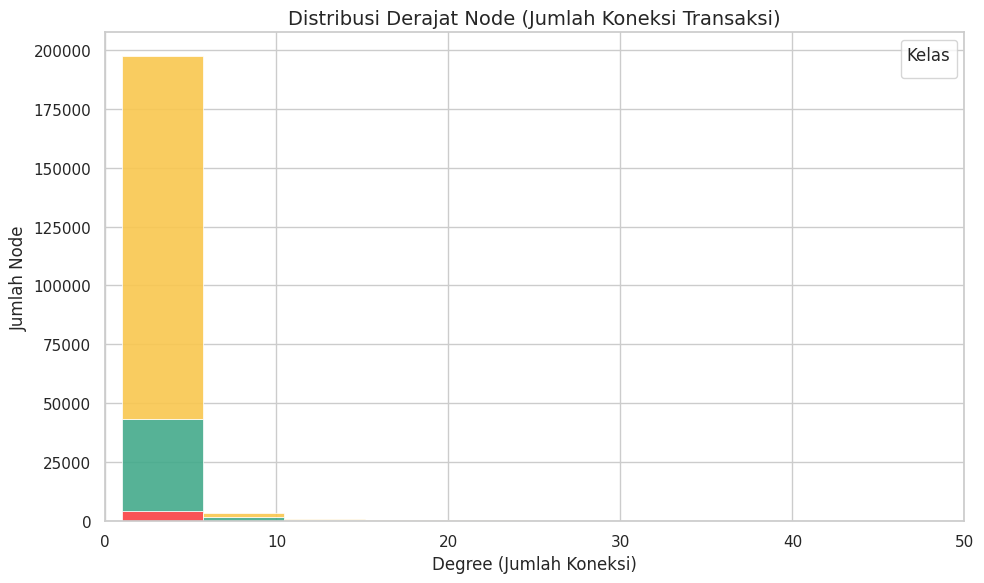

In [12]:
sns.set(style='whitegrid')
plt.rcParams.update({'figure.autolayout': True})

G = nx.from_pandas_edgelist(
    elliptic_txs_edgelist,
    source='txId1',
    target='txId2',
    create_using=nx.Graph()
)

degree_dict = dict(G.degree())
df_degree = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['degree'])
df_degree.index.name = 'txId'
df_degree.reset_index(inplace=True)

elliptic_txs_classes['txId'] = elliptic_txs_classes['txId'].astype(int)
df_merged = df_degree.merge(elliptic_txs_classes, on='txId', how='left')

class_mapping = {
    '1': 'Illicit',
    '2': 'Licit',
    'unknown': 'Unknown'
}
df_merged['class_label'] = df_merged['class'].map(class_mapping)

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_merged,
    x='degree',
    hue='class_label',
    bins=100,
    multiple='stack',
    palette={'Illicit': '#f94144', 'Licit': '#43aa8b', 'Unknown': '#f9c74f'},
    edgecolor=None,
    alpha=0.9,
)
plt.title("Distribusi Derajat Node (Jumlah Koneksi Transaksi)", fontsize=14)
plt.xlabel("Degree (Jumlah Koneksi)")
plt.ylabel("Jumlah Node")
plt.xlim(0, 50)
plt.legend(title="Kelas", loc='upper right')
plt.tight_layout()
plt.show()


Illicit (merah): Transaksi ilegal

Licit (hijau): Transaksi legal

Unknown (kuning): Transaksi tanpa label

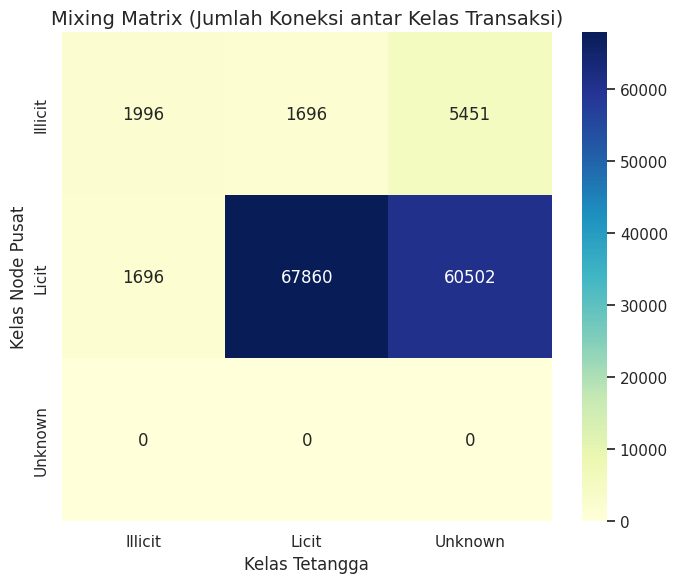

In [13]:
G = nx.from_pandas_edgelist(
    elliptic_txs_edgelist,
    source='txId1',
    target='txId2',
    create_using=nx.Graph()
)

label_map = {
    '1': 'Illicit',
    '2': 'Licit',
    'unknown': 'Unknown'
}
elliptic_txs_classes['txId'] = elliptic_txs_classes['txId'].astype(int)
elliptic_txs_classes['class_label'] = elliptic_txs_classes['class'].map(label_map)

node_label_dict = elliptic_txs_classes.set_index('txId')['class_label'].to_dict()

mixing_matrix = defaultdict(lambda: defaultdict(int))

labeled_nodes = [n for n, c in node_label_dict.items() if c in ['Illicit', 'Licit']]

for node in labeled_nodes:
    center_label = node_label_dict.get(node, 'Unknown')
    neighbors = G.neighbors(node)
    for nbr in neighbors:
        nbr_label = node_label_dict.get(nbr, 'Unknown')
        mixing_matrix[center_label][nbr_label] += 1

labels = ['Illicit', 'Licit', 'Unknown']
mixing_df = pd.DataFrame(index=labels, columns=labels)

for row_label in labels:
    for col_label in labels:
        mixing_df.loc[row_label, col_label] = mixing_matrix[row_label][col_label]

mixing_df = mixing_df.fillna(0).astype(int)

plt.figure(figsize=(7, 6))
sns.heatmap(mixing_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Mixing Matrix (Jumlah Koneksi antar Kelas Transaksi)", fontsize=14)
plt.xlabel("Kelas Tetangga")
plt.ylabel("Kelas Node Pusat")
plt.tight_layout()
plt.show()


Number of connected components: 49
Giant component - Number of nodes: 7,880
Giant component - Number of edges: 9,164


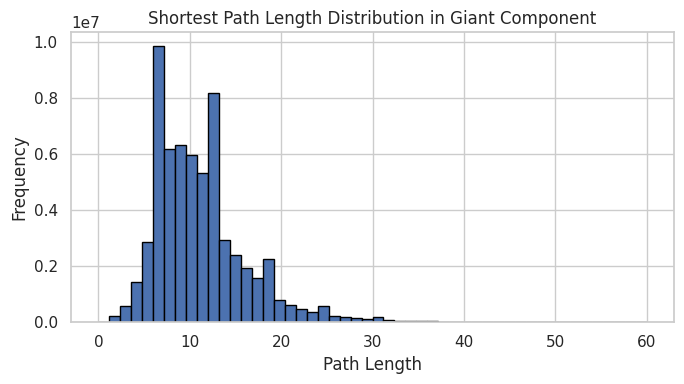

In [14]:
G = nx.from_pandas_edgelist(elliptic_txs_edgelist, source="txId1", target="txId2")

num_connected_components = nx.number_connected_components(G)
print(f"Number of connected components: {num_connected_components}")

giant_component = max(nx.connected_components(G), key=len)
G_giant = G.subgraph(giant_component)

print(f"Giant component - Number of nodes: {G_giant.number_of_nodes():,}")
print(f"Giant component - Number of edges: {G_giant.number_of_edges():,}")

path_lengths = dict(nx.shortest_path_length(G_giant))
path_lengths_values = [length for target_lengths in path_lengths.values() for length in target_lengths.values()]

plt.figure(figsize=(7, 4))
plt.hist(path_lengths_values, bins=50, edgecolor='black')
plt.title('Shortest Path Length Distribution in Giant Component')
plt.xlabel('Path Length')
plt.ylabel('Frequency')
plt.show()

# Class-Aware Centrality

##### Mengukur apakah transaksi yang illicit memiliki peran sentral lebih tinggi dalam jaringan dibandingkan licit atau unknown.

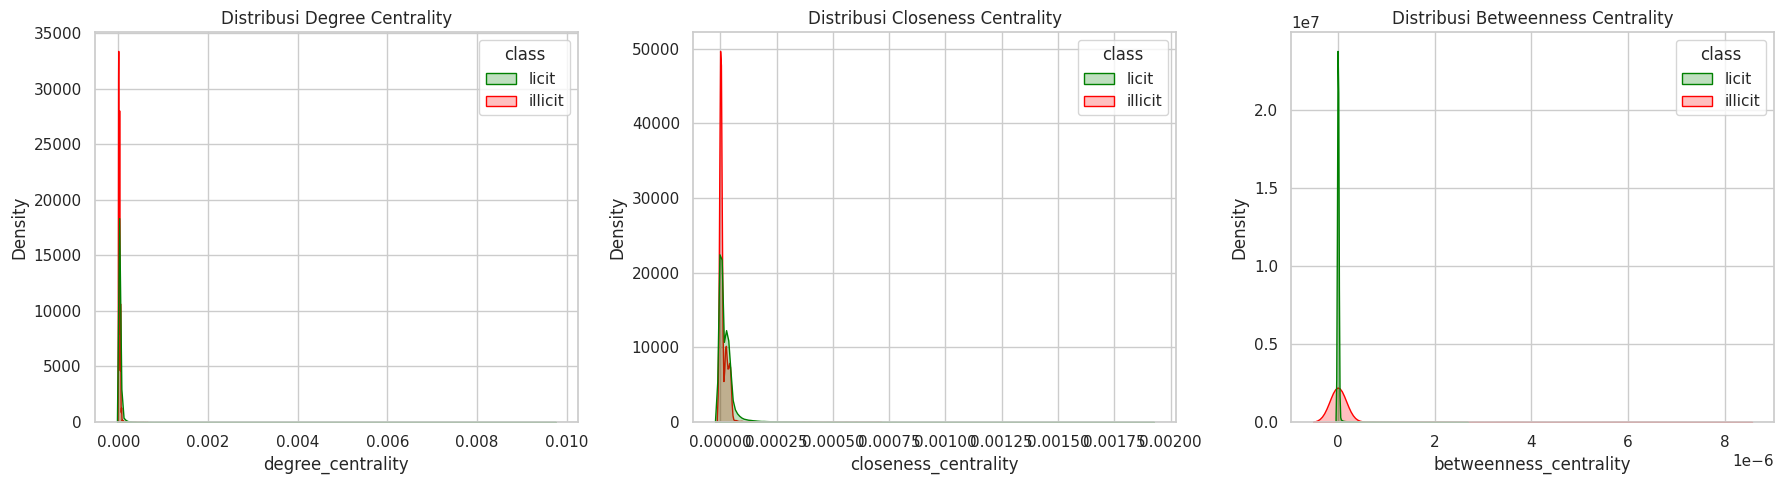

In [15]:
G = nx.from_pandas_edgelist(
    elliptic_txs_edgelist,
    source='txId1',
    target='txId2',
    create_using=nx.DiGraph()
)

class_dict = pd.Series(elliptic_txs_classes['class'].values,
                       index=elliptic_txs_classes['txId']).to_dict()
nx.set_node_attributes(G, class_dict, name='class')

valid_nodes = {k: v for k, v in class_dict.items() if v in ['1', '2']}
labeled_subgraph = G.subgraph(valid_nodes.keys()).copy()

for node in labeled_subgraph.nodes():
    labeled_subgraph.nodes[node]['class'] = {
        '1': 'illicit', '2': 'licit'
    }[labeled_subgraph.nodes[node]['class']]

deg_cent = nx.degree_centrality(labeled_subgraph)
clo_cent = nx.closeness_centrality(labeled_subgraph)
btw_cent = nx.betweenness_centrality(labeled_subgraph, k=1000, seed=42) 

df_centrality = pd.DataFrame({
    'txId': list(deg_cent.keys()),
    'degree_centrality': list(deg_cent.values()),
    'closeness_centrality': [clo_cent[n] for n in deg_cent.keys()],
    'betweenness_centrality': [btw_cent[n] for n in deg_cent.keys()],
    'class': [labeled_subgraph.nodes[n]['class'] for n in deg_cent.keys()]
})

sns.set(style='whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(['degree_centrality', 'closeness_centrality', 'betweenness_centrality']):
    sns.kdeplot(
        data=df_centrality,
        x=metric,
        hue='class',
        ax=axes[i],
        common_norm=False,
        fill=True,
        palette={'illicit': 'red', 'licit': 'green'}
    )
    axes[i].set_title(f'Distribusi {metric.replace("_", " ").title()}')

plt.tight_layout()
plt.show()

In [16]:
for col in ['degree_centrality', 'closeness_centrality', 'betweenness_centrality']:
    illicit_vals = df_centrality[df_centrality['class'] == 'illicit'][col]
    licit_vals = df_centrality[df_centrality['class'] == 'licit'][col]
    
    stat, p = mannwhitneyu(illicit_vals, licit_vals, alternative='two-sided')
    print(f"{col} → p-value: {p:.4e}")

degree_centrality → p-value: 0.0000e+00
closeness_centrality → p-value: 1.1223e-126
betweenness_centrality → p-value: 3.4027e-14


Jumlah node berlabel: 46564


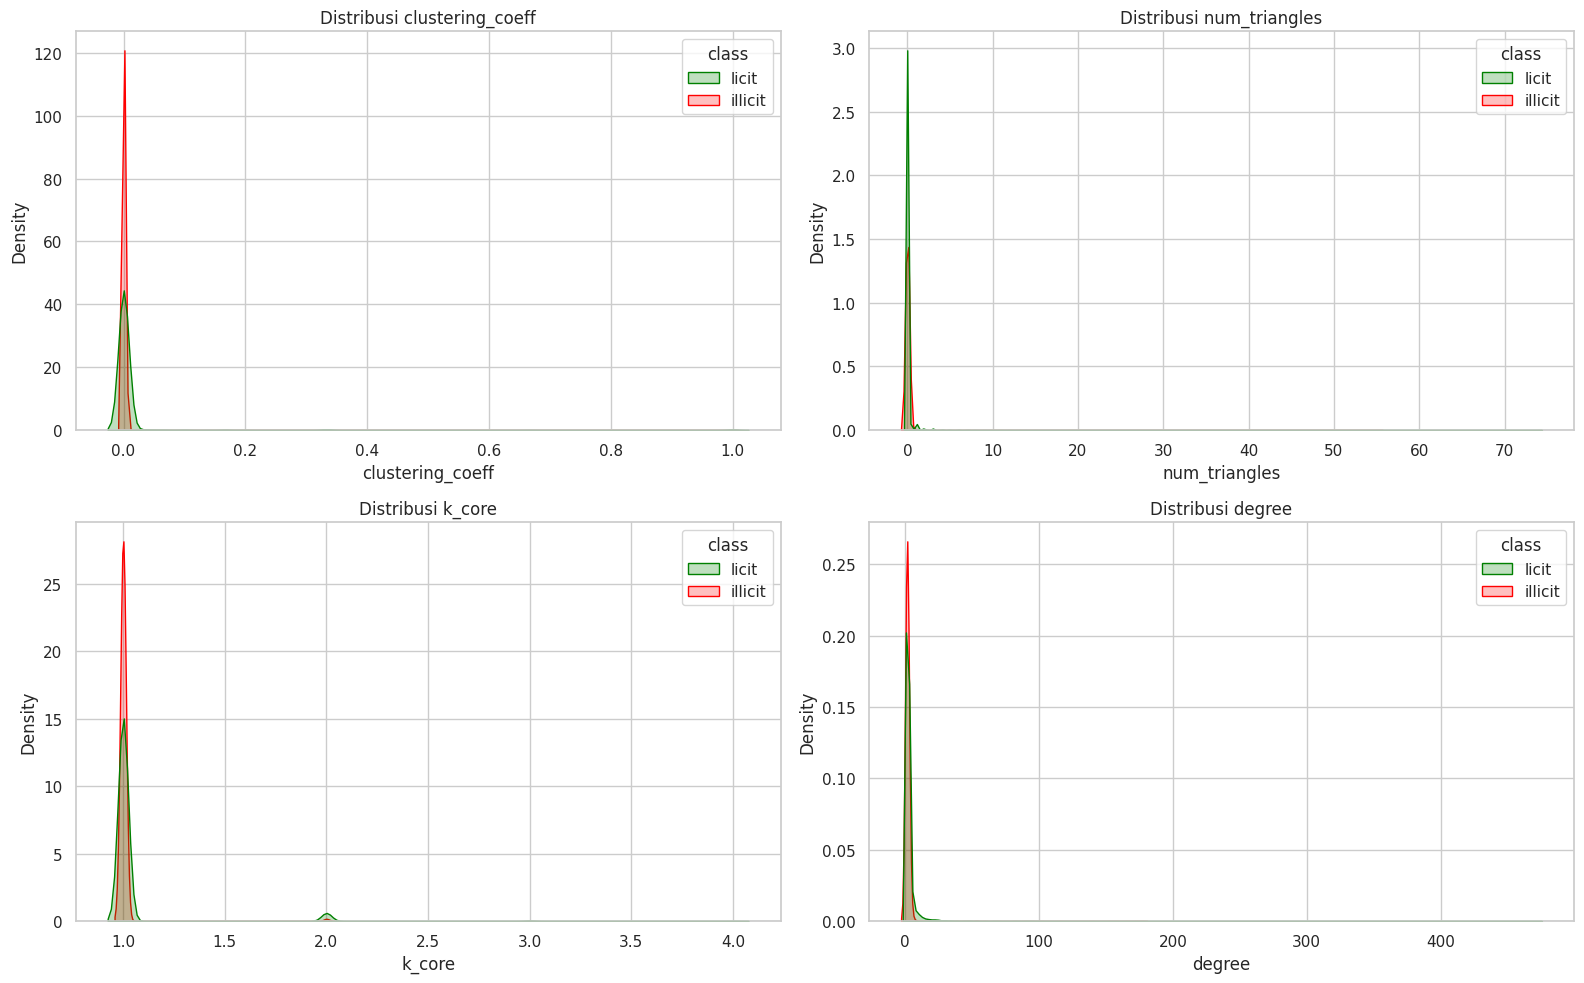

In [17]:
G = nx.from_pandas_edgelist(elliptic_txs_edgelist, source="txId1", target="txId2")

label_dict = pd.Series(elliptic_txs_classes['class'].values, index=elliptic_txs_classes['txId']).to_dict()
nx.set_node_attributes(G, label_dict, 'class')

nodes_labeled = [n for n, d in G.nodes(data=True) if d.get('class') in ['1', '2']]
print(f"Jumlah node berlabel: {len(nodes_labeled)}")

egonet_profiles = []

for node in nodes_labeled:
    ego = nx.ego_graph(G, node, radius=1)
    class_label = G.nodes[node]['class']

    clustering = nx.clustering(ego, node)
    triangles = nx.triangles(ego, node)
    k_core_num = nx.core_number(ego).get(node, 0)
    degree = G.degree[node]

    egonet_profiles.append({
        'txId': node,
        'class': 'illicit' if class_label == '1' else 'licit',
        'clustering_coeff': clustering,
        'num_triangles': triangles,
        'k_core': k_core_num,
        'degree': degree
    })

df_egonet = pd.DataFrame(egonet_profiles)

features = ['clustering_coeff', 'num_triangles', 'k_core', 'degree']

plt.figure(figsize=(16, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(data=df_egonet, x=feature, hue='class', fill=True, common_norm=False, palette={'licit':'green', 'illicit':'red'})
    plt.title(f'Distribusi {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
plt.tight_layout()
plt.show()


Top 10 nodes by degree centrality:
        Node  Degree Centrality
0      89273           0.036680
1  232438397           0.020434
2    2881273           0.018150
3  230658142           0.017007
4    2758467           0.013453
5    2881274           0.012311
6  232029206           0.007615
7   43560505           0.006346
8    2880930           0.006219
9   27405707           0.005077


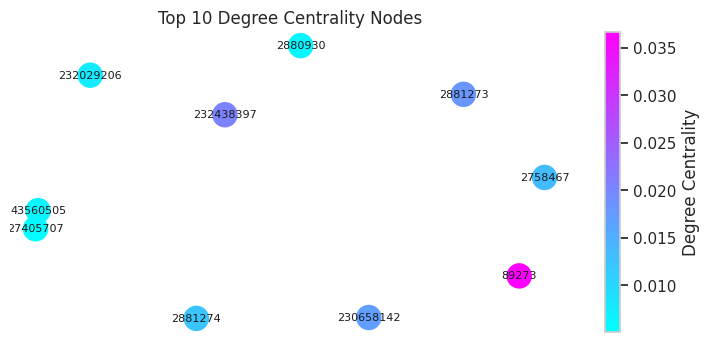

In [20]:
import matplotlib.colors as mcolors

degree_centrality = nx.degree_centrality(G_giant)
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_degree_centrality = pd.DataFrame(top_degree_centrality, columns=['Node', 'Degree Centrality'])

print("Top 10 nodes by degree centrality:")
print(df_top_degree_centrality)

top_nodes_by_ = df_top_degree_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_)
node_color = [degree_centrality[node] for node in subgraph.nodes()]

norm = mcolors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool

plt.figure(figsize=(7, 3))
nx.draw(subgraph, with_labels=True, node_size=300, edge_color='gray', font_size=8, 
        node_color=node_color_normalized, cmap=cmap)

plt.title('Top 10 Degree Centrality Nodes')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Degree Centrality')
plt.show()


Top 10 nodes by betweenness centrality:
        Node  Betweenness Centrality
0      89273                0.485234
1  232438397                0.296735
2    2758467                0.164410
3    2881273                0.156171
4    2881274                0.135059
5    2893846                0.104127
6  230402893                0.092297
7  230658142                0.087068
8   34174548                0.081942
9    2880930                0.078085


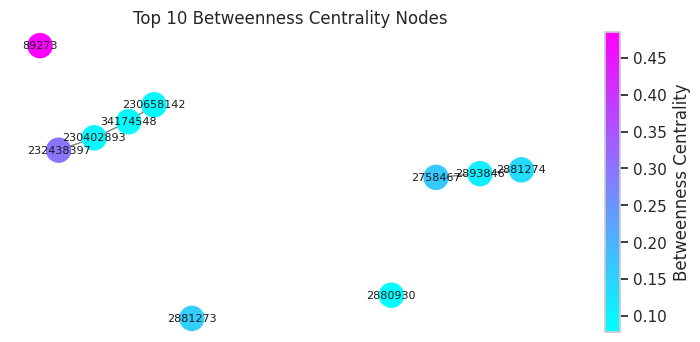

In [22]:
betweenness_centrality = nx.betweenness_centrality(G_giant)
top_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_betweenness_centrality = pd.DataFrame(top_betweenness_centrality, columns=['Node', 'Betweenness Centrality'])

print("Top 10 nodes by betweenness centrality:")
print(df_top_betweenness_centrality)

top_nodes_by_ = df_top_betweenness_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_)
node_color = [betweenness_centrality[node] for node in subgraph.nodes()]

# ✅ Gunakan mcolors
norm = mcolors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool

plt.figure(figsize=(7, 3))

nx.draw(subgraph, with_labels=True, node_size=300, edge_color='gray', font_size=8, 
        node_color=node_color_normalized, cmap=cmap)
plt.title('Top 10 Betweenness Centrality Nodes')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Betweenness Centrality')
plt.show()

Top 10 nodes by closeness centrality:
        Node  Closeness Centrality
0      89273              0.162511
1  232438397              0.155365
2  230438845              0.151394
3  230439793              0.151394
4  230683551              0.149009
5  230537117              0.148888
6  230451730              0.147738
7  232031824              0.146728
8  203465969              0.146725
9  232054853              0.146205


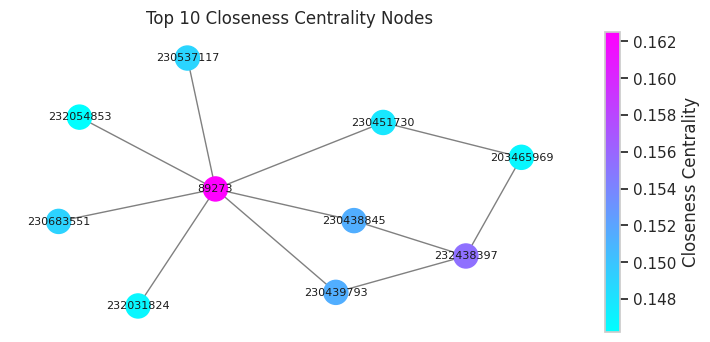

In [24]:
closeness_centrality = nx.closeness_centrality(G_giant)
top_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_closeness_centrality = pd.DataFrame(top_closeness_centrality, columns=['Node', 'Closeness Centrality'])

print("Top 10 nodes by closeness centrality:")
print(df_top_closeness_centrality)

top_nodes_by_closeness = df_top_closeness_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_closeness)
node_color = [closeness_centrality[node] for node in subgraph.nodes()]

# ✅ Gunakan mcolors, bukan plt.colors
norm = mcolors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool

plt.figure(figsize=(7, 3))

nx.draw(subgraph, with_labels=True, node_size=300, edge_color='gray', font_size=8, 
        node_color=node_color_normalized, cmap=cmap)
plt.title('Top 10 Closeness Centrality Nodes')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label='Closeness Centrality')
plt.show()

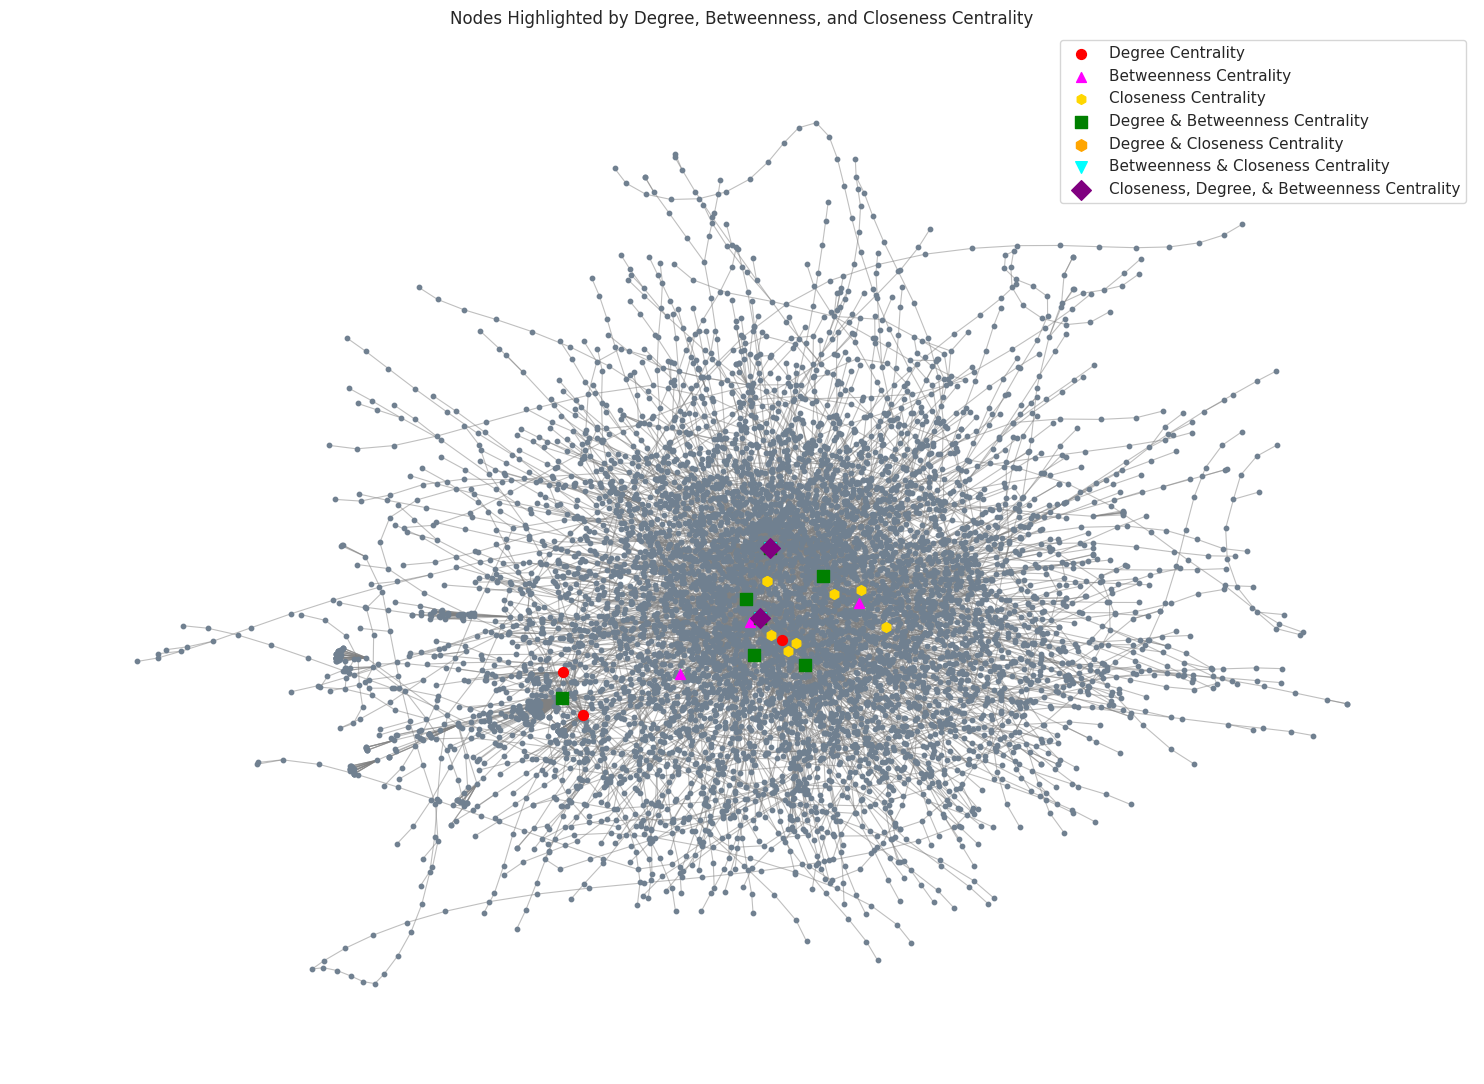

In [28]:
top_nodes_degree = set([node for node, _ in top_degree_centrality])
top_nodes_betweenness = set([node for node, _ in top_betweenness_centrality])
top_nodes_closeness = set([node for node, _ in top_closeness_centrality])

top_nodes_both = top_nodes_degree.intersection(top_nodes_betweenness)
top_nodes_closeness_and_degree = top_nodes_closeness.intersection(top_nodes_degree)
# top_nodes_closeness_and_betweenness = top_nodes_closeness.intersectionatop_nodes_betweenness
top_nodes_closeness_and_betweenness = top_nodes_closeness.intersection(top_nodes_betweenness)

top_nodes_all_three = top_nodes_closeness.intersection(top_nodes_degree).intersection(top_nodes_betweenness)

node_color = []
node_shape = []

for node in G_giant.nodes():
    if node in top_nodes_all_three:
        node_color.append('purple')
        node_shape.append('D')
    elif node in top_nodes_closeness_and_degree:
        node_color.append('orange')
        node_shape.append('h')
    elif node in top_nodes_closeness_and_betweenness:
        node_color.append('cyan')
        node_shape.append('v')
    elif node in top_nodes_both:
        node_color.append('green')
        node_shape.append('s')
    elif node in top_nodes_degree:
        node_color.append('red')
        node_shape.append('o')
    elif node in top_nodes_betweenness:
        node_color.append('magenta')
        node_shape.append('^')
    elif node in top_nodes_closeness:
        node_color.append('yellow')
        node_shape.append('h')
    else:
        node_color.append('slategrey')
        node_shape.append('o')

plt.figure(figsize=(15, 11))
pos = nx.spring_layout(G_giant)

nx.draw_networkx_nodes(G_giant, pos, node_color='slategrey', node_size=10)

nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_degree - top_nodes_both - top_nodes_closeness_and_degree), 
                       node_color='red', node_size=50, node_shape='o', 
                       label='Degree Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_betweenness - top_nodes_both - top_nodes_closeness_and_betweenness), 
                       node_color='magenta', node_size=50, node_shape='^', 
                       label='Betweenness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_closeness - top_nodes_closeness_and_degree - top_nodes_closeness_and_betweenness), 
                       node_color='gold', node_size=50, node_shape='h', 
                       label='Closeness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_both), 
                       node_color='green', node_size=80, node_shape='s', 
                       label='Degree & Betweenness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_closeness_and_degree), 
                       node_color='orange', node_size=70, node_shape='h', 
                       label='Degree & Closeness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_closeness_and_betweenness), 
                       node_color='cyan', node_size=70, node_shape='v', 
                       label='Betweenness & Closeness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_all_three), 
                       node_color='purple', node_size=100, node_shape='D', 
                       label='Closeness, Degree, & Betweenness Centrality')

nx.draw_networkx_edges(G_giant, pos, width=0.8, edge_color='gray', alpha=0.5)
plt.axis('off')
plt.title('Nodes Highlighted by Degree, Betweenness, and Closeness Centrality')
plt.legend(scatterpoints=1)
plt.show()

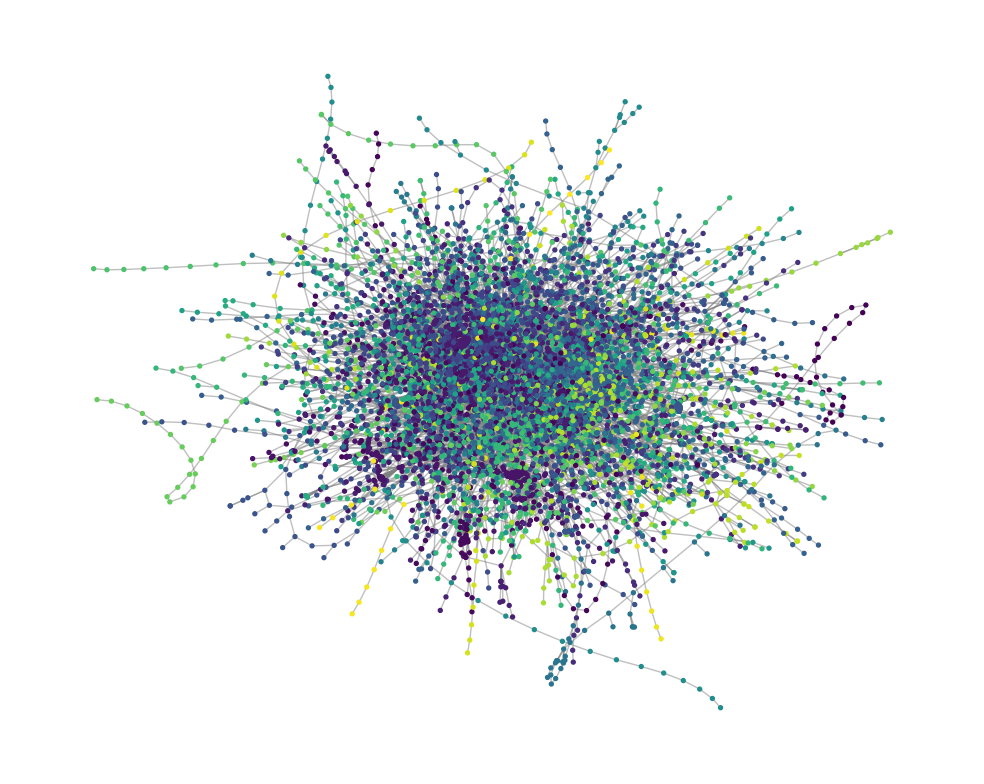

In [29]:
import community.community_louvain as community_louvain

partition = community_louvain.best_partition(G_giant)

plt.figure(figsize=(10, 8))

pos = nx.spring_layout(G_giant)
cmap = plt.get_cmap('viridis')
nx.draw_networkx_nodes(G_giant, pos, node_color=list(partition.values()), node_size=8, cmap=cmap)
nx.draw_networkx_edges(G_giant, pos, alpha=0.5, edge_color='grey')
plt.axis('off')

plt.show()

# 5. Data Preparation for Graph Neural Networks

## 5.1 Converting Data to Tensor Format

In [18]:
tx_id_mapping = {tx_id: idx for idx, tx_id in enumerate(elliptic_txs_features['txID'])}
edges_with_features = elliptic_txs_edgelist[elliptic_txs_edgelist['txId1'].isin(list(tx_id_mapping.keys()))\
                                            & elliptic_txs_edgelist['txId2'].isin(list(tx_id_mapping.keys()))]

edges_with_features['Id1'] = edges_with_features['txId1'].map(tx_id_mapping)
edges_with_features['Id2'] = edges_with_features['txId2'].map(tx_id_mapping)

edges_with_features

,txId1,txId2,Id1,Id2
0,230425980,5530458,0,1
1,232022460,232438397,2,3
2,230460314,230459870,4,5
3,230333930,230595899,6,7
4,232013274,232029206,8,9
...,...,...,...,...
234350,158365409,157930723,203602,201430
234351,188708874,188708879,203603,203099
234352,157659064,157659046,201921,202042
234353,87414554,106877725,201480,201368


In [19]:
edge_index = torch.tensor(edges_with_features[['Id1', 'Id2']].values.T, dtype=torch.long)
edge_index

tensor([[     0,      2,      4,  ..., 201921, 201480, 201954],
        [     1,      3,      5,  ..., 202042, 201368, 201756]])

In [20]:
node_features = torch.tensor(elliptic_txs_features.drop(columns=['txID']).values, 
                             dtype=torch.float)
print(node_features.shape)
node_features

torch.Size([203769, 166])


tensor([[ 1.0000e+00, -1.7147e-01, -1.8467e-01,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01],
        [ 1.0000e+00, -1.7148e-01, -1.8467e-01,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01],
        [ 1.0000e+00, -1.7211e-01, -1.8467e-01,  ..., -1.8367e-01,
         -1.2061e-01, -1.1979e-01],
        ...,
        [ 4.9000e+01, -1.7201e-01, -7.8182e-02,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01],
        [ 4.9000e+01, -1.7284e-01, -1.7662e-01,  ..., -1.4060e-01,
          1.5197e+00,  1.5214e+00],
        [ 4.9000e+01, -1.2037e-02, -1.3228e-01,  ..., -1.4060e-01,
          1.5197e+00,  1.5214e+00]])

## 5.2 Label Encoding: Changing Text to Numbers

In [21]:
le = LabelEncoder()
class_labels = le.fit_transform(elliptic_txs_classes['class'])
node_labels = torch.tensor(class_labels, dtype=torch.long)
original_labels = le.inverse_transform(class_labels)

print(original_labels)
print(class_labels)
print(node_labels)

['unknown' 'unknown' 'unknown' ... '1' 'unknown' 'unknown']
[2 2 2 ... 0 2 2]
tensor([2, 2, 2,  ..., 0, 2, 2])


## 5.3 Data Splitting with the Masking Method

In [22]:
data = Data(x=node_features, 
            edge_index=edge_index, 
            y=node_labels)

data = data.to(device)

In [23]:
known_mask   = (data.y == 0) | (data.y == 1)  # Only nodes with known labels licit or illicit
unknown_mask = data.y == 2

In [24]:
num_known_nodes = known_mask.sum().item()
permutations = torch.randperm(num_known_nodes)
train_size = int(0.8 * num_known_nodes)
val_size = int(0.1 * num_known_nodes)
test_size = num_known_nodes - train_size - val_size

total = np.sum([train_size, val_size, test_size])

print(f"""Number of observations per split
    Training   : {train_size:10,} ({100*train_size/total:0.2f} %)
    Validation : {val_size:10,} ({100*val_size/total:0.2f} %)
    Testing    : {test_size:10,} ({100*test_size/total:0.2f} %)
""")

Number of observations per split
    Training   :     37,251 (80.00 %)
    Validation :      4,656 (10.00 %)
    Testing    :      4,657 (10.00 %)



In [25]:
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

train_indices = known_mask.nonzero(as_tuple=True)[0][permutations[:train_size]]
val_indices = known_mask.nonzero(as_tuple=True)[0][permutations[train_size:train_size + val_size]]
test_indices = known_mask.nonzero(as_tuple=True)[0][permutations[train_size + val_size:]]

data.train_mask[train_indices] = True
data.val_mask[val_indices] = True
data.test_mask[test_indices] = True

data.train_mask

tensor([False, False, False,  ...,  True, False, False])

In [26]:
train_licit, train_illicit = (data.y[data.train_mask] == 1).sum().item(), (data.y[data.train_mask] == 0).sum().item()
val_licit, val_illicit = (data.y[data.val_mask] == 1).sum().item(), (data.y[data.val_mask] == 0).sum().item()
test_licit, test_illicit = (data.y[data.test_mask] == 1).sum().item(), (data.y[data.test_mask] == 0).sum().item()

train_total = train_licit + train_illicit
val_total = val_licit + val_illicit
test_total = test_licit + test_illicit

train_licit_pct = (train_licit / train_total) * 100
train_illicit_pct = (train_illicit / train_total) * 100
val_licit_pct = (val_licit / val_total) * 100
val_illicit_pct = (val_illicit / val_total) * 100
test_licit_pct = (test_licit / test_total) * 100
test_illicit_pct = (test_illicit / test_total) * 100

pd.DataFrame({
    'Set': ['Training', 'Validation', 'Testing'],
    'Total Count': [train_total, val_total, test_total],
    'Licit': [train_licit, val_licit, test_licit],
    'Licit (%)': [train_licit_pct, val_licit_pct, test_licit_pct],
    'Illicit': [train_illicit, val_illicit, test_illicit],
    'Illicit (%)': [train_illicit_pct, val_illicit_pct, test_illicit_pct]
})

,Set,Total Count,Licit,Licit (%),Illicit,Illicit (%)
0,Training,37251,33649,90.330461,3602,9.669539
1,Validation,4656,4148,89.089347,508,10.910653
2,Testing,4657,4222,90.659223,435,9.340777


In [27]:
mapped_classes = np.array(['illicit', 'licit'])

# 6. GNN Model Implementation and Training

## 6.1 Model Architecture

In [27]:
metrics_per_gnn = {
    'gcn': {
        'val': {
            'precisions': [],  
            'recalls': [],  
            'f1_scores': [], 
            'probas': [], 
            'auc_roc': [],  
            'avg_precision': [], 
            'loss': [] 
        },
        'test': {
            'licit': {
                'probas': [],
                'predictions': [] 
            },
            'illicit': {
                'probas': [],
                'predictions': []
            },
            'confusion_matrix': [] 
        }
    },
    'gat': { 
        'val': {
            'precisions': [], 
            'recalls': [], 
            'f1_scores': [],  
            'probas': [], 
            'auc_roc': [],  
            'avg_precision': [],
            'loss': []  
        },
        'test': {
            'licit': {
                'probas': [],
                'predictions': [] 
            },
            'illicit': {
                'probas': [],
                'predictions': []
            },
            'confusion_matrix': [] 
        }
    },
    'gin': {  
        'val': {
            'precisions': [], 
            'recalls': [], 
            'f1_scores': [],  
            'probas': [], 
            'auc_roc': [], 
            'avg_precision': [], 
            'loss': []  
        },
        'test': {
            'licit': {
                'probas': [],
                'predictions': []  
            },
            'illicit': {
                'probas': [],
                'predictions': []
            },
            'confusion_matrix': []  
        }
    }
}

In [28]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GAT(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, num_heads=8):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_node_features, 8, heads=num_heads, dropout=0.6)
        self.conv2 = GATConv(8 * num_heads, num_classes, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)



class GIN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GIN, self).__init__()
        
        # 1st GIN layer.
        nn1 = torch.nn.Sequential(
            torch.nn.Linear(num_node_features, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64)
        )
        self.conv1 = GINConv(nn1)
        
        # 2nd GIN layer.
        nn2 = torch.nn.Sequential(
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64)
        )
        self.conv2 = GINConv(nn2)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.fc(x)
        
        return F.log_softmax(x, dim=1)

## 6.2 Helper Functions for Training and Evaluation

In [29]:
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        
        correct = (pred[mask] == data.y[mask]).sum().item()
        accuracy = correct / mask.sum().item()

        y_true = data.y[mask].cpu().numpy()
        y_pred = pred[mask].cpu().numpy()

        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
    return metrics

def predict(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
    return pred

def predict_probabilities(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        probabilities = torch.exp(out)
    return probabilities


In [30]:
def train_gnn(num_epochs, data, model, optimizer, criterion):
    train_losses = []
    train_accuracies = []
    train_precisions = []
    train_recalls = []
    train_f1_scores = []

    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1_scores = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], 
                         data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        pred_train = out[data.train_mask].argmax(dim=1)
        correct_train = (pred_train == data.y[data.train_mask]).sum()
        train_acc = int(correct_train) / int(data.train_mask.sum())
        train_accuracies.append(train_acc)

        y_true_train = data.y[data.train_mask].cpu().numpy()
        y_pred_train = pred_train.cpu().numpy()

        train_prec = precision_score(y_true_train, y_pred_train, average='weighted', zero_division=0)
        train_rec = recall_score(y_true_train, y_pred_train, average='weighted', zero_division=0)
        train_f1 = f1_score(y_true_train, y_pred_train, average='weighted', zero_division=0)

        train_precisions.append(train_prec)
        train_recalls.append(train_rec)
        train_f1_scores.append(train_f1)
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            out = model(data)
            pred_val = out[data.val_mask].argmax(dim=1)
            correct_val = (pred_val == data.y[data.val_mask]).sum()
            val_acc = int(correct_val) / int(data.val_mask.sum())
            val_accuracies.append(val_acc)

            y_true_val = data.y[data.val_mask].cpu().numpy()
            y_pred_val = pred_val.cpu().numpy()

            val_prec = precision_score(y_true_val, y_pred_val, average='weighted', zero_division=0)
            val_rec = recall_score(y_true_val, y_pred_val, average='weighted', zero_division=0)
            val_f1 = f1_score(y_true_val, y_pred_val, average='weighted', zero_division=0)

            val_precisions.append(val_prec)
            val_recalls.append(val_rec)
            val_f1_scores.append(val_f1)

        if epoch % 10 == 0:        
            print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Train - Acc: {train_acc:.4f} - Prec: {train_prec:.4f} - Rec: {train_rec:.4f} - F1: {train_f1:.4f}')
            print(f'                         Val   - Acc: {val_acc:.4f} - Prec: {val_prec:.4f} - Rec: {val_rec:.4f} - F1: {val_f1:.4f}')        

    return {
        'train': {
            'losses': train_losses,
            'accuracies': train_accuracies,
            'precisions': train_precisions,
            'recalls': train_recalls,
            'f1_scores': train_f1_scores,
        },
        'val': {
            'accuracies': val_accuracies,
            'precisions': val_precisions,
            'recalls': val_recalls,
            'f1_scores': val_f1_scores,            
        }
    }

## 6.2 Training and Evaluation

### 6.2.1 Logistic Regression

In [41]:
# Konversi tensor PyTorch ke NumPy
X_all = node_features.numpy()
y_all = node_labels.numpy()

train_idx = data.train_mask.cpu().numpy()
val_idx = data.val_mask.cpu().numpy()
test_idx = data.test_mask.cpu().numpy()

X_train = X_all[train_idx]
y_train = y_all[train_idx]
X_val = X_all[val_idx]
y_val = y_all[val_idx]
X_test = X_all[test_idx]
y_test = y_all[test_idx]

X_train_full = np.concatenate([X_train, X_val], axis=0)
y_train_full = np.concatenate([y_train, y_val], axis=0)

models = {
    "Logistic Regression": LogisticRegression(max_iter=NUM_EPOCHS, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=NUM_EPOCHS, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=4, random_state=42),
    "SVM": SVC(class_weight='balanced')
}

summary = {}
for name, model in models.items():
    model.fit(X_train_full, y_train_full)
    y_pred = model.predict(X_test)
    summary[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1_score": f1_score(y_test, y_pred)
    }

df_results = pd.DataFrame(summary).T
print(df_results)


                     accuracy  precision    recall  f1_score
Logistic Regression  0.891346   0.991795  0.887494  0.936750
Random Forest        0.987760   0.988048  0.998579  0.993285
XGBoost              0.990122   0.990141  0.999053  0.994577
SVM                  0.912819   0.992006  0.911180  0.949877


### 6.2.1 GCN

In [38]:
model = GCN(num_node_features=data.num_features, num_classes=len(le.classes_)).to(device)
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=0.01, 
                             weight_decay=0.0005)
criterion = torch.nn.CrossEntropyLoss() 

data = data.to(device)

In [39]:
train_val_metrics = train_gnn(NUM_EPOCHS, 
                              data, 
                              model, 
                              optimizer, 
                              criterion)

metrics_per_gnn['gcn']['val']['precisions'] = train_val_metrics['val']['precisions']

Epoch 010, Loss: 0.4143, Train - Acc: 0.8988 - Prec: 0.8662 - Rec: 0.8988 - F1: 0.8737
                         Val   - Acc: 0.8915 - Prec: 0.8586 - Rec: 0.8915 - F1: 0.8595
Epoch 020, Loss: 0.3295, Train - Acc: 0.9047 - Prec: 0.8763 - Rec: 0.9047 - F1: 0.8674
                         Val   - Acc: 0.8950 - Prec: 0.8743 - Rec: 0.8950 - F1: 0.8548
Epoch 030, Loss: 0.2562, Train - Acc: 0.8915 - Prec: 0.8907 - Rec: 0.8915 - F1: 0.8911
                         Val   - Acc: 0.8877 - Prec: 0.8846 - Rec: 0.8877 - F1: 0.8861
Epoch 040, Loss: 0.2294, Train - Acc: 0.9072 - Prec: 0.8893 - Rec: 0.9072 - F1: 0.8937
                         Val   - Acc: 0.9003 - Prec: 0.8810 - Rec: 0.9003 - F1: 0.8818
Epoch 050, Loss: 0.2182, Train - Acc: 0.9073 - Prec: 0.8846 - Rec: 0.9073 - F1: 0.8751
                         Val   - Acc: 0.8969 - Prec: 0.8764 - Rec: 0.8969 - F1: 0.8625
Epoch 060, Loss: 0.2058, Train - Acc: 0.9190 - Prec: 0.9073 - Rec: 0.9190 - F1: 0.9002
                         Val   - Acc: 0.912

In [40]:
model.eval()
with torch.no_grad():
    test_metrics = evaluate(model, data, data.test_mask)
    test_acc = test_metrics.get('accuracy')
    test_prec = test_metrics.get('precision')
    test_rec = test_metrics.get('recall')
    test_f1 = test_metrics.get('f1_score')
    print(f'Test Acc: {test_acc:.4f} - Prec: {test_prec:.4f} - Rec: {test_rec:.4f} - F1: {test_f1:.4f}')

model_path = 'gcn_model.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

Test Acc: 0.9431 - Prec: 0.9394 - Rec: 0.9431 - F1: 0.9353
Model saved to gcn_model.pth


In [42]:
train_pred = predict(model, data)[data.train_mask]
test_pred = predict(model, data)[data.test_mask]

In [43]:
print("Classification Report - GCN")

y_true_train = data.y[data.train_mask].cpu().numpy()
y_pred_train = train_pred.cpu().numpy()
report_train = classification_report(y_true_train, y_pred_train, target_names=mapped_classes)
print("TRAIN")
print(report_train)

y_true_test = data.y[data.test_mask].cpu().numpy()
y_pred_test = test_pred.cpu().numpy()
report_test = classification_report(y_true_test, y_pred_test, target_names=mapped_classes)
print("TEST")
print(report_test)

Classification Report

    TRAIN
---------
              precision    recall  f1-score   support

     illicit       0.82      0.43      0.56      3602
       licit       0.94      0.99      0.97     33649

    accuracy                           0.94     37251
   macro avg       0.88      0.71      0.76     37251
weighted avg       0.93      0.94      0.93     37251

    TEST
--------
              precision    recall  f1-score   support

     illicit       0.86      0.47      0.61       435
       licit       0.95      0.99      0.97      4222

    accuracy                           0.94      4657
   macro avg       0.90      0.73      0.79      4657
weighted avg       0.94      0.94      0.94      4657



### 6.2.2 GAT

In [44]:
model = GAT(num_node_features=data.num_features, num_classes=len(le.classes_)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0005)
criterion = torch.nn.CrossEntropyLoss()  # Since we have a multiclass classification problem.

data = data.to(device)

In [45]:
train_val_metrics = train_gnn(NUM_EPOCHS, 
                              data, 
                              model, 
                              optimizer, 
                              criterion)

metrics_per_gnn['gat']['val']['precisions'] = train_val_metrics['val']['precisions']

Epoch 010, Loss: 0.7362, Train - Acc: 0.8829 - Prec: 0.8634 - Rec: 0.8829 - F1: 0.8716
                         Val   - Acc: 0.8868 - Prec: 0.8844 - Rec: 0.8868 - F1: 0.8856
Epoch 020, Loss: 0.5729, Train - Acc: 0.8984 - Prec: 0.8747 - Rec: 0.8984 - F1: 0.8820
                         Val   - Acc: 0.8567 - Prec: 0.8935 - Rec: 0.8567 - F1: 0.8707
Epoch 030, Loss: 0.5020, Train - Acc: 0.9057 - Prec: 0.8814 - Rec: 0.9057 - F1: 0.8842
                         Val   - Acc: 0.8804 - Prec: 0.9045 - Rec: 0.8804 - F1: 0.8897
Epoch 040, Loss: 0.4479, Train - Acc: 0.9128 - Prec: 0.8958 - Rec: 0.9128 - F1: 0.8901
                         Val   - Acc: 0.9156 - Prec: 0.9196 - Rec: 0.9156 - F1: 0.9174
Epoch 050, Loss: 0.4142, Train - Acc: 0.9143 - Prec: 0.8990 - Rec: 0.9143 - F1: 0.8925
                         Val   - Acc: 0.9287 - Prec: 0.9256 - Rec: 0.9287 - F1: 0.9269
Epoch 060, Loss: 0.3809, Train - Acc: 0.9184 - Prec: 0.9084 - Rec: 0.9184 - F1: 0.8970
                         Val   - Acc: 0.939

In [46]:
model.eval()
with torch.no_grad():
    test_metrics = evaluate(model, data, data.test_mask)
    test_acc = test_metrics.get('accuracy')
    test_prec = test_metrics.get('precision')
    test_rec = test_metrics.get('recall')
    test_f1 = test_metrics.get('f1_score')
    print(f'Test Acc: {test_acc:.4f} - Prec: {test_prec:.4f} - Rec: {test_rec:.4f} - F1: {test_f1:.4f}')

model_path = 'gat_model.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

Test Acc: 0.9472 - Prec: 0.9438 - Rec: 0.9472 - F1: 0.9411
Model saved to gat_model.pth


In [48]:
train_pred = predict(model, data)[data.train_mask]
test_pred = predict(model, data)[data.test_mask]

In [49]:
print("Classification Report - GAT")

y_true_train = data.y[data.train_mask].cpu().numpy()
y_pred_train = train_pred.cpu().numpy()
report_train = classification_report(y_true_train, y_pred_train, target_names=mapped_classes)
print("TRAIN")
print(report_train)

y_true_test = data.y[data.test_mask].cpu().numpy()
y_pred_test = test_pred.cpu().numpy()
report_test = classification_report(y_true_test, y_pred_test, target_names=mapped_classes)
print("TEST")
print(report_test)

Classification Report

    TRAIN
---------
              precision    recall  f1-score   support

     illicit       0.90      0.51      0.65      3602
       licit       0.95      0.99      0.97     33649

    accuracy                           0.95     37251
   macro avg       0.92      0.75      0.81     37251
weighted avg       0.95      0.95      0.94     37251

    TEST
--------
              precision    recall  f1-score   support

     illicit       0.86      0.52      0.65       435
       licit       0.95      0.99      0.97      4222

    accuracy                           0.95      4657
   macro avg       0.91      0.75      0.81      4657
weighted avg       0.94      0.95      0.94      4657



### 6.3 GIN

In [31]:
model = GIN(num_node_features=data.num_features, num_classes=len(le.classes_)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0005)
criterion = torch.nn.CrossEntropyLoss()
data = data.to(device)

In [36]:
train_val_metrics = train_gnn(1000, 
                              data, 
                              model, 
                              optimizer, 
                              criterion)

metrics_per_gnn['gin']['val']['precisions'] = train_val_metrics['val']['precisions']

Epoch 010, Loss: 0.0839, Train - Acc: 0.9701 - Prec: 0.9700 - Rec: 0.9701 - F1: 0.9701
                         Val   - Acc: 0.9601 - Prec: 0.9599 - Rec: 0.9601 - F1: 0.9568
Epoch 020, Loss: 0.0668, Train - Acc: 0.9760 - Prec: 0.9754 - Rec: 0.9760 - F1: 0.9752
                         Val   - Acc: 0.9661 - Prec: 0.9654 - Rec: 0.9661 - F1: 0.9642
Epoch 030, Loss: 0.0592, Train - Acc: 0.9802 - Prec: 0.9798 - Rec: 0.9802 - F1: 0.9798
                         Val   - Acc: 0.9654 - Prec: 0.9644 - Rec: 0.9654 - F1: 0.9639
Epoch 040, Loss: 0.0854, Train - Acc: 0.9701 - Prec: 0.9708 - Rec: 0.9701 - F1: 0.9704
                         Val   - Acc: 0.9641 - Prec: 0.9631 - Rec: 0.9641 - F1: 0.9623
Epoch 050, Loss: 0.0624, Train - Acc: 0.9784 - Prec: 0.9779 - Rec: 0.9784 - F1: 0.9779
                         Val   - Acc: 0.9661 - Prec: 0.9650 - Rec: 0.9661 - F1: 0.9651
Epoch 060, Loss: 0.0509, Train - Acc: 0.9828 - Prec: 0.9825 - Rec: 0.9828 - F1: 0.9825
                         Val   - Acc: 0.965

In [40]:
model.eval()
with torch.no_grad():
    test_metrics = evaluate(model, data, data.test_mask)
    test_acc = test_metrics.get('accuracy')
    test_prec = test_metrics.get('precision')
    test_rec = test_metrics.get('recall')
    test_f1 = test_metrics.get('f1_score')
    print(f'Test Acc: {test_acc:.4f} - Prec: {test_prec:.4f} - Rec: {test_rec:.4f} - F1: {test_f1:.4f}')

model_path = 'gin_model1.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

Test Acc: 0.9691 - Prec: 0.9683 - Rec: 0.9691 - F1: 0.9685
Model saved to gin_model1.pth


In [41]:
train_pred = predict(model, data)[data.train_mask]
test_pred = predict(model, data)[data.test_mask]

In [42]:
print("Classification Report - GIN")

y_true_train = data.y[data.train_mask].cpu().numpy()
y_pred_train = train_pred.cpu().numpy()
report_train = classification_report(y_true_train, y_pred_train, target_names=mapped_classes)
print("TRAIN")
print(report_train)


y_true_test = data.y[data.test_mask].cpu().numpy()
y_pred_test = test_pred.cpu().numpy()
report_test = classification_report(y_true_test, y_pred_test, target_names=mapped_classes)
print("TEST")
print(report_test)

Classification Report - GIN
TRAIN
              precision    recall  f1-score   support

     illicit       0.97      0.96      0.97      3602
       licit       1.00      1.00      1.00     33649

    accuracy                           0.99     37251
   macro avg       0.98      0.98      0.98     37251
weighted avg       0.99      0.99      0.99     37251

TEST
              precision    recall  f1-score   support

     illicit       0.86      0.80      0.83       435
       licit       0.98      0.99      0.98      4222

    accuracy                           0.97      4657
   macro avg       0.92      0.89      0.91      4657
weighted avg       0.97      0.97      0.97      4657



In [28]:
train_tx_ids = elliptic_txs_features['txID'][data.train_mask.cpu().numpy()].values

x_train = data.x[data.train_mask].cpu().numpy()
y_train = data.y[data.train_mask].cpu().numpy()

df_train_with_txid = pd.DataFrame(x_train, columns=[f"feature_{i}" for i in range(data.num_features)])

df_train_with_txid.insert(0, 'txID', train_tx_ids)
df_train_with_txid["label"] = y_train

df_train_with_txid.to_csv("elliptic_training_data_with_txid.csv", index=False)

print("Training data with txID saved to elliptic_training_data_with_txid.csv")

Training data with txID saved to elliptic_training_data_with_txid.csv


In [31]:
elliptic_txs_edgelist.to_csv("elliptic_txs_edgelist.csv", index=False)
print("Edgelist data saved to elliptic_txs_edgelist.csv")

Edgelist data saved to elliptic_txs_edgelist.csv
